# Building Your First Image Search with CLIP

In this notebook, you'll learn how to build a simple image search system using CLIP (Contrastive Language-Image Pre-training). CLIP can understand both text and images, making it perfect for searching images using natural language descriptions.

## What you'll learn:
- Load a pre-trained CLIP model
- Process images and text
- Find the most similar images to a text query

## Step 1: Helper functions

First, let's define a simple helper function to display images:

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from typing import List


def display_grid(images: List[Image.Image], *args, **kwargs):
    """
    Wrap the make_grid function from torchvision accepting PIL.Image instances
    instead of tensors. Every other arguments or keyword arguments is passed
    to make_grid.

    Images are going to be resized and center-cropped to 256x256 to fit
    in the grid.
    """
    transform = T.Compose(
        [
            T.Resize(256),  # resize shorter side to 256
            T.CenterCrop(256),  # center crop to 256x256 square
            T.ToTensor(),
        ]
    )

    tensors = [transform(img) for img in images]
    grid = torchvision.utils.make_grid(tensors, *args, **kwargs)
    _, sub = plt.subplots(dpi=300)
    sub.imshow(grid.permute(1, 2, 0))
    sub.axis("off")
    plt.show()

## Step 2: Import Libraries and Load the Model

Now let's import the necessary libraries and load a pre-trained CLIP model from Hugging Face.

In [2]:
from transformers import CLIPProcessor, CLIPModel

# Load the CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name, fast_processor=True)

print("Model loaded successfully!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Model loaded successfully!


## Step 3: Load Dataset

Let's load a dataset of images:

In [3]:
from datasets import load_dataset
from tqdm import tqdm

# Load dataset
# We use this Realworld Q/A dataset because it is small (765) but
# pretty diverse
dataset = load_dataset("xai-org/RealworldQA", split="test")

README.md:   0%|          | 0.00/947 [00:00<?, ?B/s]

data/test-00000-of-00002.parquet:   0%|          | 0.00/337M [00:00<?, ?B/s]

data/test-00001-of-00002.parquet:   0%|          | 0.00/341M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/765 [00:00<?, ? examples/s]

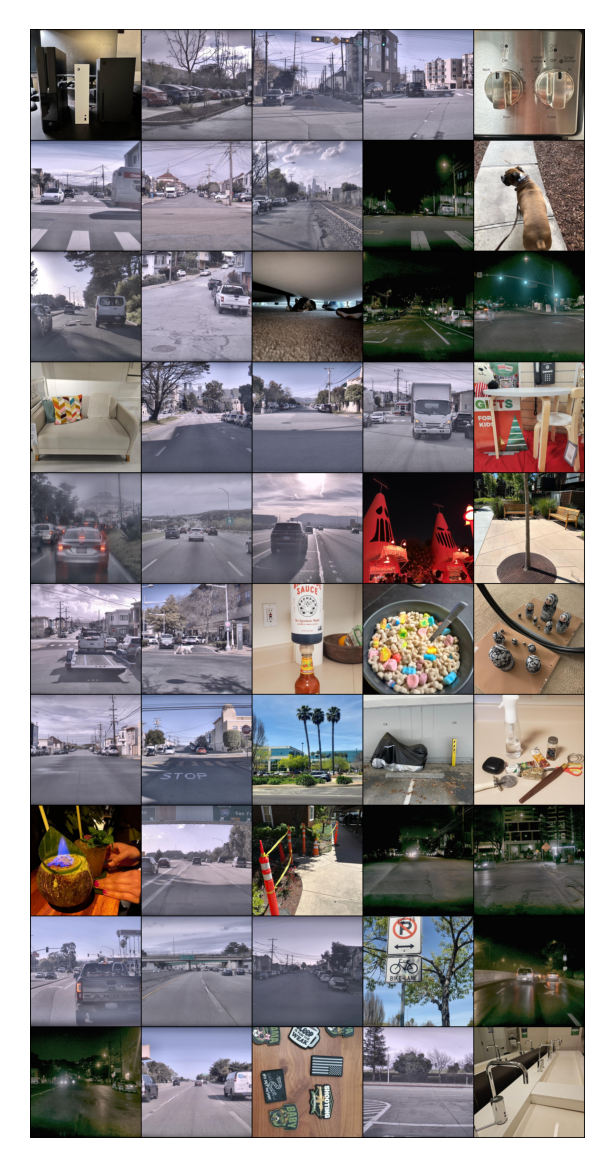

In [ ]:
# Let's look at what we got. Let's display a few images in a grid
images = dataset['image']
display_grid(images[:50], nrow=5)

## Step 4: Create Image Embeddings

Now we'll convert our images into embeddings (numerical representations) that CLIP can work with. These embeddings capture the visual features of each image.

In [6]:
import numpy as np


# Process images and get embeddings
def get_image_embeddings_batch(images, batch_size=32):
    """
    Process images in batches for speed
    """

    all_embeddings = []

    for i in tqdm(
        range(0, len(images), batch_size), total=int(np.ceil(len(images) / batch_size))
    ):
        
        # Get a batch of images
        batch = images[i : i + batch_size]

        # Run the pre-processor to get the inputs to the CLIP model
        inputs = processor(images=batch, return_tensors="pt", padding=True)

        # Get image features from the model
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)

        # NOTE: since we will be using cosine similarity, we pre-normalize the embeddings
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        all_embeddings.append(image_features)

        if (i + batch_size) % 100 == 0 or (i + batch_size) >= len(images):
            print(f"Processed {min(i + batch_size, len(images))} images...")
    
    # Right now the list all_embeddings is a list of batches, we
    # collapse it into a list of embeddings
    return torch.cat(all_embeddings, dim=0)


print("Creating embeddings for all batches of images...")
image_embeddings = get_image_embeddings_batch(images)
print(f"Created embeddings with shape: {image_embeddings.shape}")

Creating embeddings for all batches of images...


100%|██████████| 24/24 [00:25<00:00,  1.07s/it]

Processed 765 images...
Created embeddings with shape: torch.Size([765, 512])


## Step 5: Search Images with Text

Here's where the magic happens! We'll create a function that takes a text query and finds the most similar images.

In [7]:
def search_images(
    image_embeddings: List[torch.Tensor],
    query_text: str,
    top_k: int = 5,
    plot: bool = False,
):
    """
    Given a set of image embeddings and a text query, returns the first top_k matches
    with the highest cosine-similarity scores. 

    The image embeddings are assumed pre-normalized.
    """

    # Tokenize the text
    inputs = processor(text=[query_text], return_tensors="pt", padding=True)

    # Get text embedding
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)

    print(
        f"Text has been transformed to embedding vector of shape {text_features[0].shape} ..."
    )

    # We use cosine similarity as matching score:
    # cosine_similarity = (A · B) / (||A|| × ||B||)
    #  so we need to:
    # 1 - Normalize text features
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # 2 - Normalize image embeddings
    # (we already did during pre-computation!)

    # 3 - Now the formula reduces to just the matrix multiplication
    similarities = torch.matmul(text_features, image_embeddings.T)

    # Sort the similarities and get the _indices_ of the first "top_k" results
    top_indices = similarities[0].argsort(descending=True)[:top_k]

    scores = similarities[0][top_indices]

    if plot:

        for i, score in zip(top_indices, scores):
            print(f"{i+1} - {score:.3f}")

        display_grid([images[int(i)] for i in top_indices], nrow=5)

    return top_indices, scores

## Step 6: Try Some Searches

Now let's test our image search system with some queries!

Text has been transformed to embedding vector of shape torch.Size([512]) ...
10 - 0.252
179 - 0.251
355 - 0.249


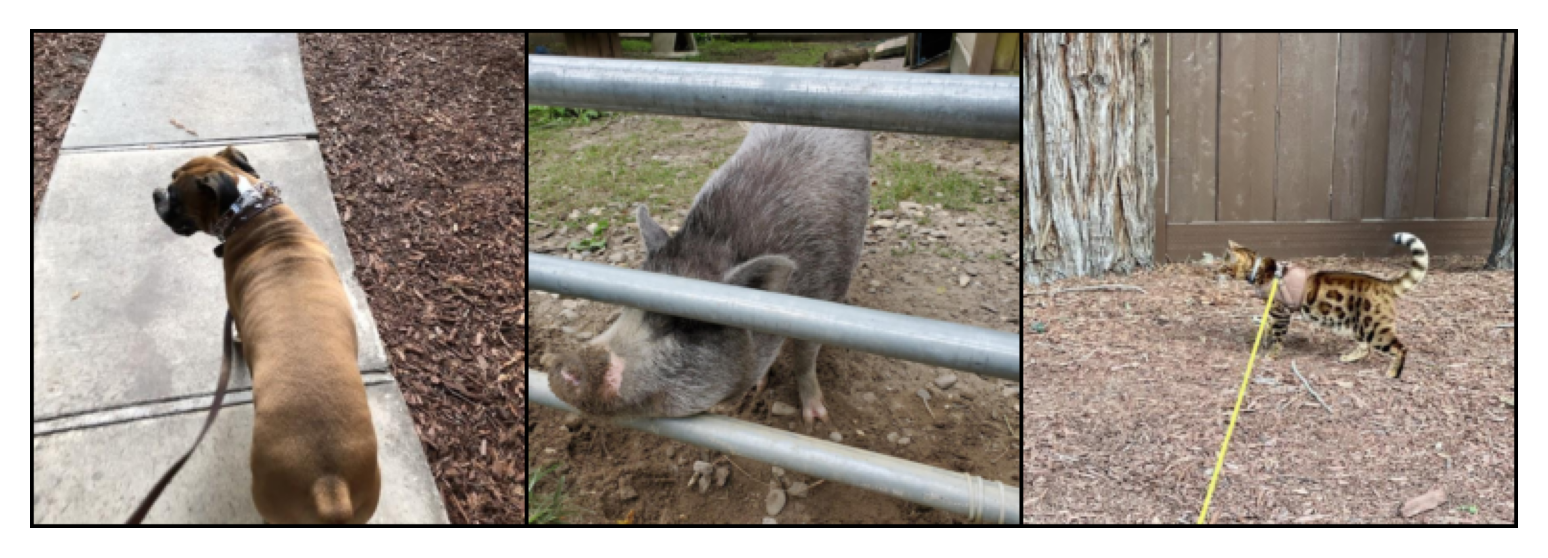

In [8]:
indices, scores = search_images(image_embeddings, "An animal", top_k=3, plot=True)

Text has been transformed to embedding vector of shape torch.Size([512]) ...
93 - 0.286
736 - 0.269
294 - 0.268


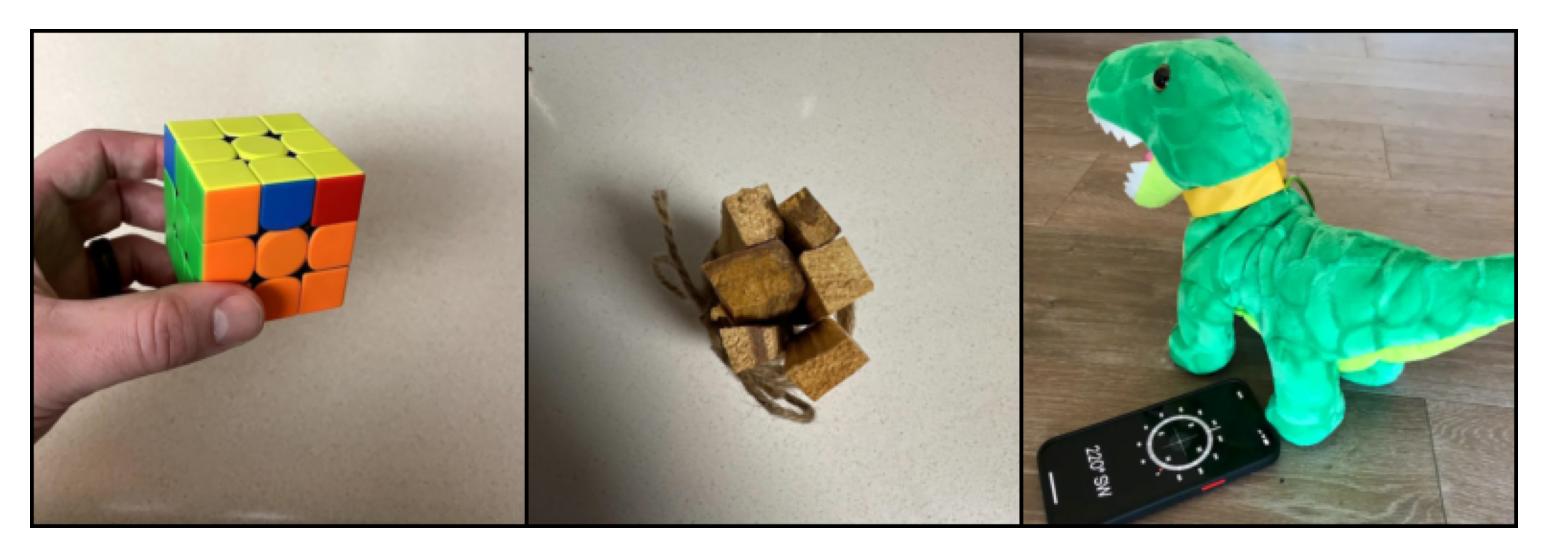

(tensor([ 92, 735, 293]), tensor([0.2862, 0.2686, 0.2681]))

In [9]:
search_images(image_embeddings, "A picture of a toy", top_k=3, plot=True)

Text has been transformed to embedding vector of shape torch.Size([512]) ...
533 - 0.295
388 - 0.295
100 - 0.295


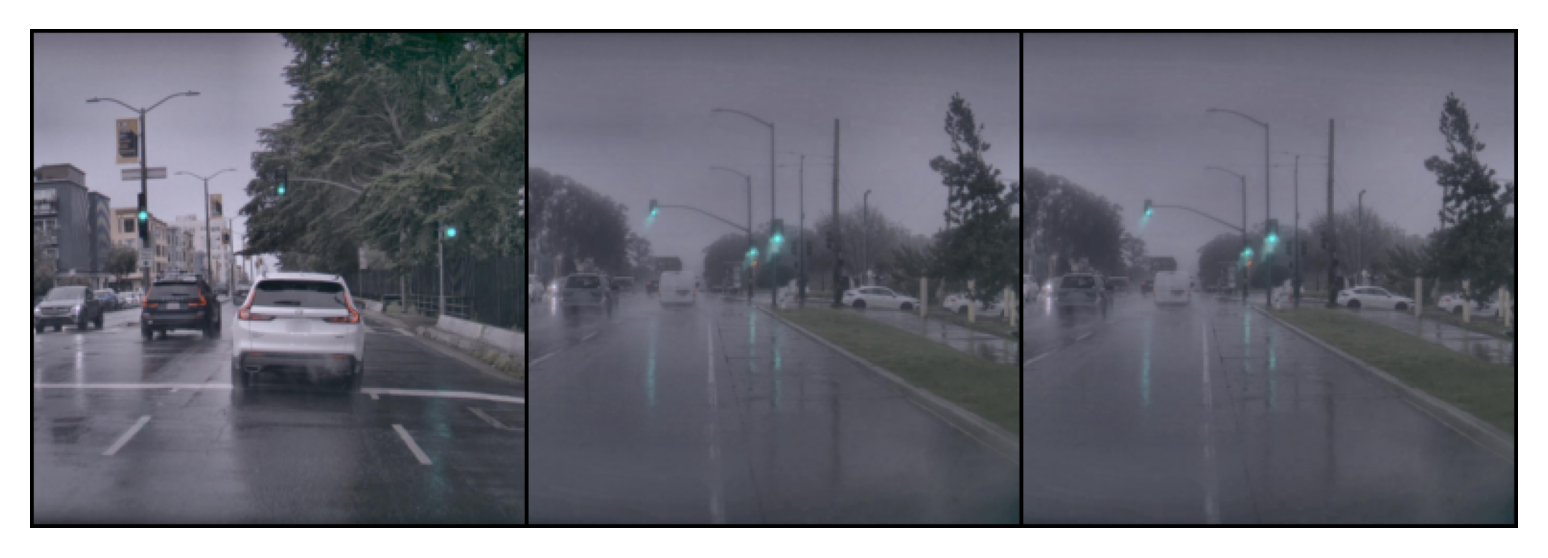

(tensor([532, 387,  99]), tensor([0.2951, 0.2948, 0.2948]))

In [10]:
search_images(image_embeddings, "A city road on a rainy day", top_k=3, plot=True)

## Conclusions

We've seen how CLIP allows us to build very quickly a basic image search engine, which given a text query returns matching images.

This is just scratching the surface of a real image search engine. Real engines are significantly more complex, involving hybrid searches, vector databases, re-ranking and a lot of other tricks to get to a great performance.

However, even a basic system such as ours can be helpful and constitute the basis for those more complicated systems.